In [40]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from numpy.random import randn

In [2]:
train_data = {
  'good': True,
  'bad': False,
  'happy': True,
  'sad': False,
  'not good': False,
  'not bad': True,
  'not happy': False,
  'not sad': True,
  'very good': True,
  'very bad': False,
  'very happy': True,
  'very sad': False,
  'i am happy': True,
  'this is good': True,
  'i am bad': False,
  'this is bad': False,
  'i am sad': False,
  'this is sad': False,
  'i am not happy': False,
  'this is not good': False,
  'i am not bad': True,
  'this is not sad': True,
  'i am very happy': True,
  'this is very good': True,
  'i am very bad': False,
  'this is very sad': False,
  'this is very happy': True,
  'i am good not bad': True,
  'this is good not bad': True,
  'i am bad not good': False,
  'i am good and happy': True,
  'this is not good and not happy': False,
  'i am not at all good': False,
  'i am not at all bad': True,
  'i am not at all happy': False,
  'this is not at all sad': True,
  'this is not at all happy': False,
  'i am good right now': True,
  'i am bad right now': False,
  'this is bad right now': False,
  'i am sad right now': False,
  'i was good earlier': True,
  'i was happy earlier': True,
  'i was bad earlier': False,
  'i was sad earlier': False,
  'i am very bad right now': False,
  'this is very good right now': True,
  'this is very sad right now': False,
  'this was bad earlier': False,
  'this was very good earlier': True,
  'this was very bad earlier': False,
  'this was very happy earlier': True,
  'this was very sad earlier': False,
  'i was good and not bad earlier': True,
  'i was not good and not happy earlier': False,
  'i am not at all bad or sad right now': True,
  'i am not at all good or happy right now': False,
  'this was not happy and not good earlier': False,
}

test_data = {
  'this is happy': True,
  'i am good': True,
  'this is not happy': False,
  'i am not good': False,
  'this is not bad': True,
  'i am not sad': True,
  'i am very good': True,
  'this is very bad': False,
  'i am very sad': False,
  'this is bad not good': False,
  'this is good and happy': True,
  'i am not good and not happy': False,
  'i am not at all sad': True,
  'this is not at all good': False,
  'this is not at all bad': True,
  'this is good right now': True,
  'this is sad right now': False,
  'this is very bad right now': False,
  'this was good earlier': True,
  'i was not happy and not good earlier': False,
}

In [12]:
def create_vocab(train_data):
    train_vocab = list(set([w for text in train_data.keys() for w in text.split(" ")]))
    word_to_idx = { w: i for i, w in enumerate(train_vocab) }
    idx_to_word = { i: w for i, w in enumerate(train_vocab) }
    return train_vocab, word_to_idx, idx_to_word

In [13]:
def createInputs(text):
    inputs = []
    for w in text.split(" "):
        v = np.zeros((vocab_size, 1))
        v[word_to_idx[w]] = 1
        inputs.append(v)
    return inputs

In [32]:
def softmax(xs):
  # Applies the Softmax Function to the input array.
  return np.exp(xs) / sum(np.exp(xs))

In [33]:
def processData(data, model, backprop=True):
    items = list(data.items())
    random.shuffle(items)
    loss = 0
    num_correct = 0

    for x, y in items:
        inputs = createInputs(x)
        target = int(y)

        # forward
        out, _ = model.forward(inputs)
        probs = softmax(out)

        loss -= np.log(probs[target])
        num_correct += int(np.argmax(probs) == target)

        if backprop:
            d_L_d_y = probs
            d_L_d_y[target] -= 1
            model.backprop(d_L_d_y)
    return loss/len(data), num_correct/len(data)

In [34]:
def train(model, train_data, test_data, num_epoch=500):
    for epoch in range(num_epoch):
        train_loss, train_acc = processData(train_data, model)

        if epoch % 50 == 9:
            print("--- Epoch %d" % (epoch + 1))
            print("Train:\tLoss %.3f | Accuracy: %.3f" % (train_loss, train_acc))
            test_loss, test_acc = processData(test_data, model, backprop=False)
            print("Test:\tLoss %.3f | Accuracy: %.3f" % (test_loss, test_acc))
            train_accs.append(train_acc)
            test_accs.append(test_acc)

In [35]:
class RNN:
    def __init__(self, input_size, output_size, hidden_size=128):
        self.Whh = randn(hidden_size, hidden_size) / 1000
        self.Wxh = randn(hidden_size, input_size) / 1000
        self.Why = randn(output_size, hidden_size) / 1000
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        h = np.zeros((self.Whh.shape[0], 1))
        self.last_inputs = inputs
        self.last_hs = { 0: h }

        for i, x in enumerate(inputs):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            self.last_hs[i+1] = h
        y = self.Why @ h + self.by
        return y, h

    def backprop(self, d_y, lr=2e-2):
        n = len(self.last_inputs)
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y

        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)

        d_h = self.Why.T @ d_y
        
        for t in reversed(range(n)):
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)
            d_bh += temp
            d_Whh += temp @ self.last_hs[t].T
            d_Wxh += temp @ self.last_inputs[t].T
            d_h = self.Whh @ temp
        
    # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)

    # Update weights and biases using gradient descent.
        self.Whh -= lr * d_Whh
        self.Wxh -= lr * d_Wxh
        self.Why -= lr * d_Why
        self.bh -= lr * d_bh
        self.by -= lr * d_by    

In [36]:
vocab, word_to_idx, idx_to_word = create_vocab(train_data)
vocab_size = len(vocab)
print(f"{vocab_size} unique words found")

18 unique words found


In [37]:
model = RNN(vocab_size, 2)

In [38]:
train_accs, test_accs = [], []
train(model, train_data, test_data)

--- Epoch 10
Train:	Loss 0.691 | Accuracy: 0.552
Test:	Loss 0.697 | Accuracy: 0.500


/tmp/ipykernel_31/1784281097.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Train:\tLoss %.3f | Accuracy: %.3f" % (train_loss, train_acc))
/tmp/ipykernel_31/1784281097.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Test:\tLoss %.3f | Accuracy: %.3f" % (test_loss, test_acc))


--- Epoch 60
Train:	Loss 0.692 | Accuracy: 0.552
Test:	Loss 0.697 | Accuracy: 0.500
--- Epoch 110
Train:	Loss 0.684 | Accuracy: 0.534
Test:	Loss 0.698 | Accuracy: 0.500
--- Epoch 160
Train:	Loss 0.677 | Accuracy: 0.534
Test:	Loss 0.721 | Accuracy: 0.400
--- Epoch 210
Train:	Loss 0.667 | Accuracy: 0.655
Test:	Loss 0.713 | Accuracy: 0.450
--- Epoch 260
Train:	Loss 0.514 | Accuracy: 0.793
Test:	Loss 0.583 | Accuracy: 0.800
--- Epoch 310
Train:	Loss 0.212 | Accuracy: 0.948
Test:	Loss 0.283 | Accuracy: 0.800
--- Epoch 360
Train:	Loss 0.113 | Accuracy: 0.983
Test:	Loss 0.632 | Accuracy: 0.650
--- Epoch 410
Train:	Loss 0.020 | Accuracy: 1.000
Test:	Loss 0.019 | Accuracy: 1.000
--- Epoch 460
Train:	Loss 0.009 | Accuracy: 1.000
Test:	Loss 0.009 | Accuracy: 1.000


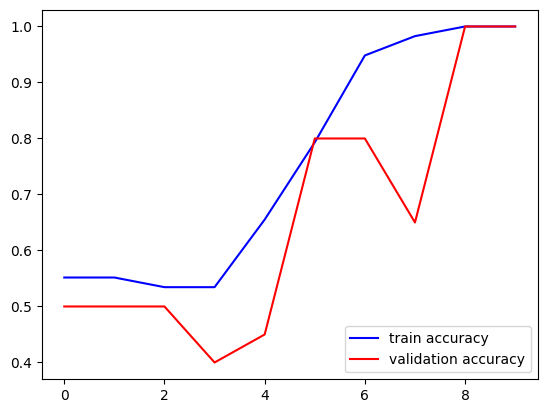

In [41]:
plt.plot(train_accs, c="b", label="train accuracy")
plt.plot(test_accs, c="r", label="validation accuracy")
plt.legend(loc="lower right")
plt.show()